# Assignment 4 - Disparity Estimation with Semi-Global Matching

In [2]:
%%javascript
IPython.OutputArea.auto_scroll_threshold = 9999;

<IPython.core.display.Javascript object>

In [3]:
# Enable autoreloading if import packages are changed
%load_ext autoreload
%autoreload 2

In [4]:
import os 
import cv2
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
from PIL import Image

plt.rcParams['figure.figsize'] = [20, 12]

'''
ADJUSTABLE PARAMETERS:
downsample_factor: increase to make the loaded images smaller
max_disparity: decrease to consider fewer disparities
'''
downsample_factor = 8 # For the submission, use value of 4
max_disparity = 220 // downsample_factor

## Load and Display Base and Matching Images

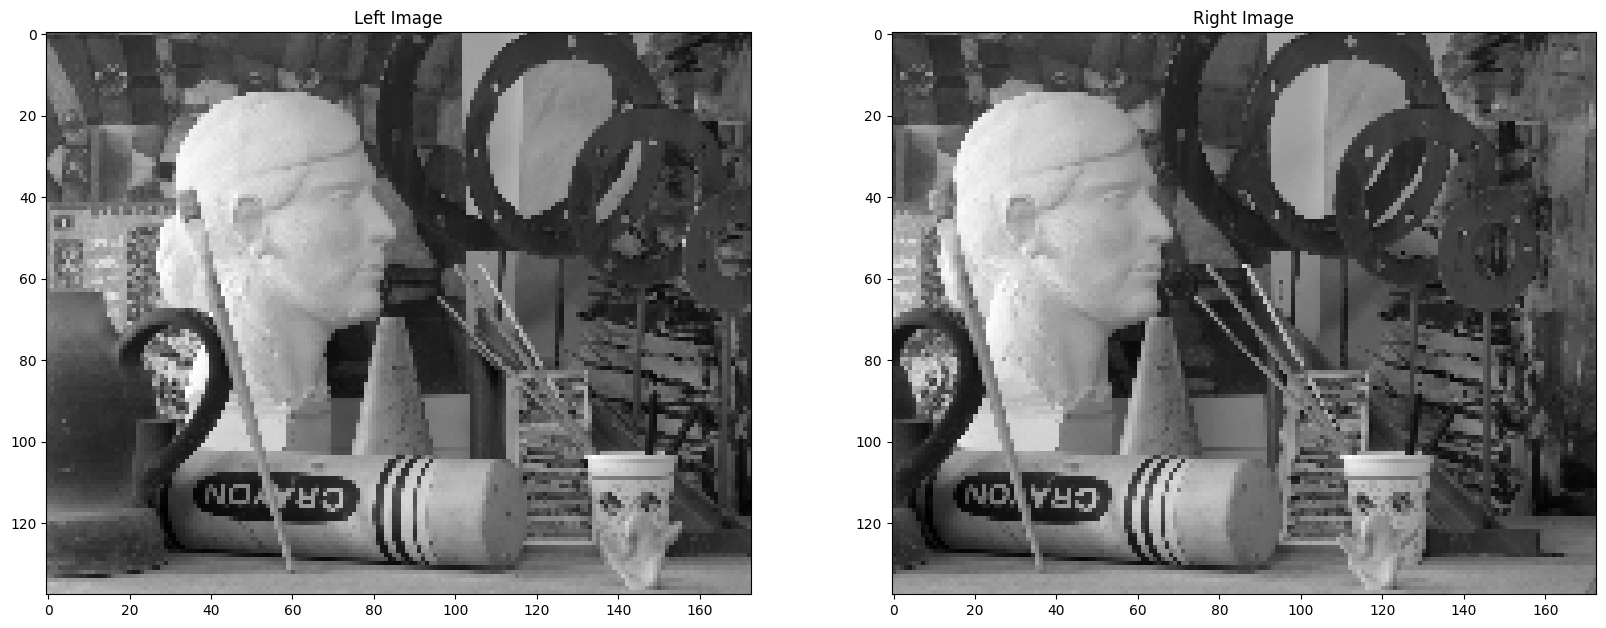

In [5]:
def load_images(image_pair_name, downsample_factor):
    def _load_single_image(image_pair_name, format_number,downsample_factor):
        image_path = os.path.join('Middlebury', image_pair_name, 'view{}.png'.format(format_number))
        image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
        if downsample_factor != 1:
            resize_height = image.shape[0] // downsample_factor
            resize_width = image.shape[1] // downsample_factor
            image = cv2.resize(image, (resize_width, resize_height))
        return image
    left = _load_single_image(image_pair_name, 1, downsample_factor)
    right = _load_single_image(image_pair_name, 5, downsample_factor)
    return left, right

def display_single_image(ax,image, title, epipolar_line_y):
    ax.imshow(image, cmap='gray')
    ax.set_title(title)
    if epipolar_line_y:
        ax.axhline(y=epipolar_line_y, color='red', linestyle='--', linewidth=2)

def display_images(left, right, epipolar_line_y=None):
    joined_gray = np.concatenate([left, right], axis=1)
    fig, axs = plt.subplots(1,2)
    display_single_image(axs[0],left,'Left Image', epipolar_line_y)
    display_single_image(axs[1],right,'Right Image', epipolar_line_y)
    plt.show()


Il, Ir = load_images("Art", downsample_factor=downsample_factor)
display_images(Il, Ir)

## Define Helper Function: Produce Shifted Image

In [6]:
Ir.shape

(138, 173)

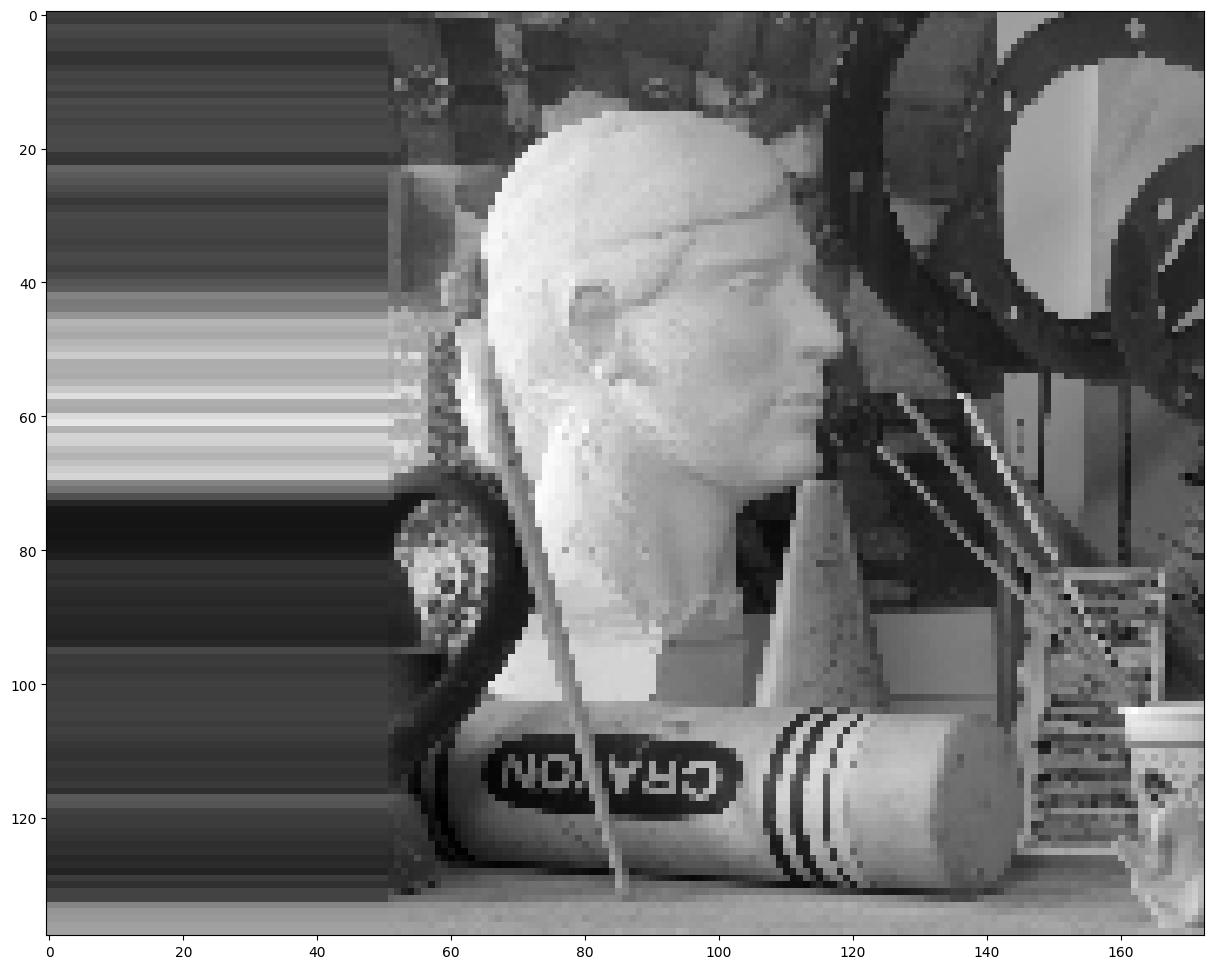

In [7]:

def produce_shifted_image(image, shift_columns):
    '''
    Shift the image to the right. This function is useful for implementing Q1
    Inputs: image: Grayscale, (Height x Width), 
             shift_columns: non negative integer for how far to shift the image to the right
    Output: the image, shifted to the right by shift columns. The rightmost column is copied to maintain the image size. 
    '''

    if shift_columns == 0:
        return image
    first_column = image[:,0]
    shifts = np.tile(first_column, (shift_columns,1)).T
    cut_image=image[:,:-shift_columns]
    image = np.concatenate([shifts,cut_image],axis=1)
    return image

shift = 50
shifted_image = produce_shifted_image(Ir, shift)
plt.imshow(shifted_image, cmap='gray')
plt.show()

## Q1: Compute the Data Term

In [8]:
def compute_data_term(Il, Ir, max_disparity, patch_size=5):
    '''
    Compute the data term: the RMSE between patches. 
    Input:  left (base) and right (match) image: Grayscale, (Height x Width), 
            max_disparity: non negative integer, the largest disparity value considered by the data term
            patch_size: non_negative, odd, integer. RMSE will be calculated in a window of 
            dimensions (patch_size, patch_size) centered around the point of interest.
    Output: data_term: a (height x Width x max_disparity) numpy matrix, storing all of the rmse for 
            all considered disparities at all pixels. More concretely, the value of data_term[y,x,d] will be 
            the RMSE of matching point (y,x) of the base image to point (y, x-d) of the matching image
            In cases where the window for RMSE goes out of frame, you can assume reflecting boundary conditions.
    '''
    ######################################################################################################
    # TODO Q1: Implement the data term                                                                   #
    # See lecture 6 part B slide 4                                                                       #
    ######################################################################################################
    
    # *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****  
    h, w  = Il.shape  
    r = (patch_size-1)//2
    data_term = np.zeros((h, w, max_disparity))
    
    for y in range(r, h - r):
        for x in range(r, w - r):
            # Define the patch in the left image
            patch_left = Il[y-r:y+r+1, x-r:x+r+1]
            for d in range(max_disparity):
                if x-r-d >= 0:
                    patch_right = Ir[y-r:y+r+1, x-r-d:x+r+1-d]
                # Calculate RMSE and store in data_term
                rmse = np.sqrt(np.mean((patch_left - patch_right)**2))
                data_term[y, x, d] = rmse
    # *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
    return data_term


In [9]:
data_term = compute_data_term(Il, Ir, max_disparity)

In [10]:
data_term.shape

(138, 173, 27)

## Q2: Visualize the Data Term

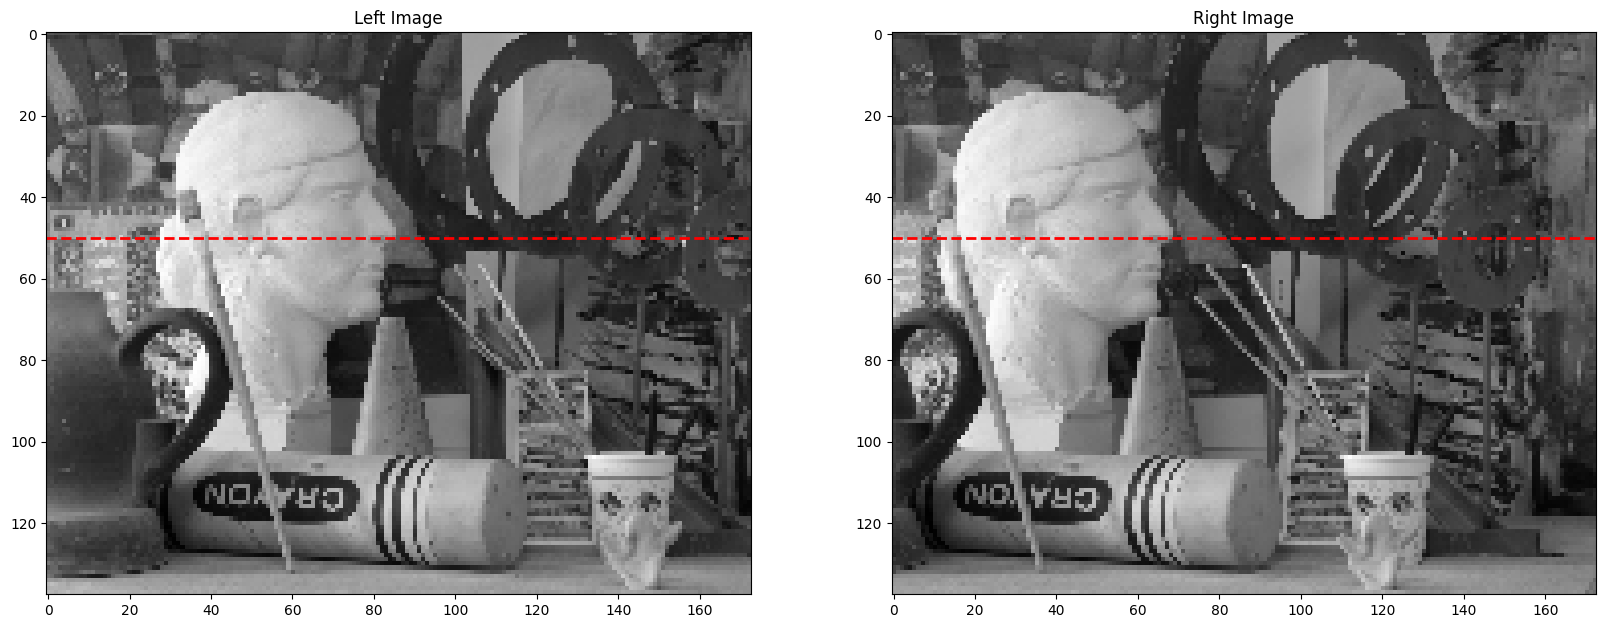

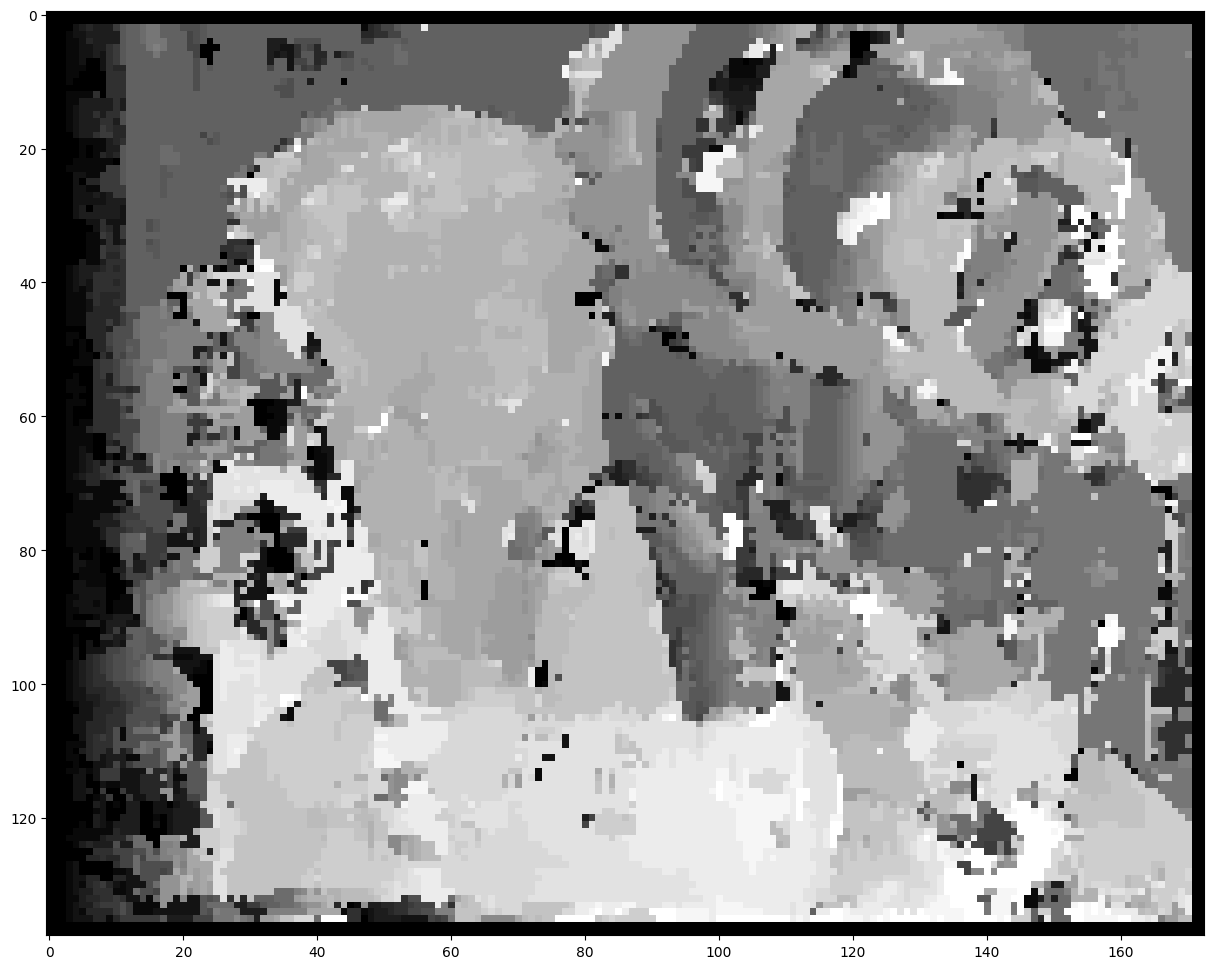

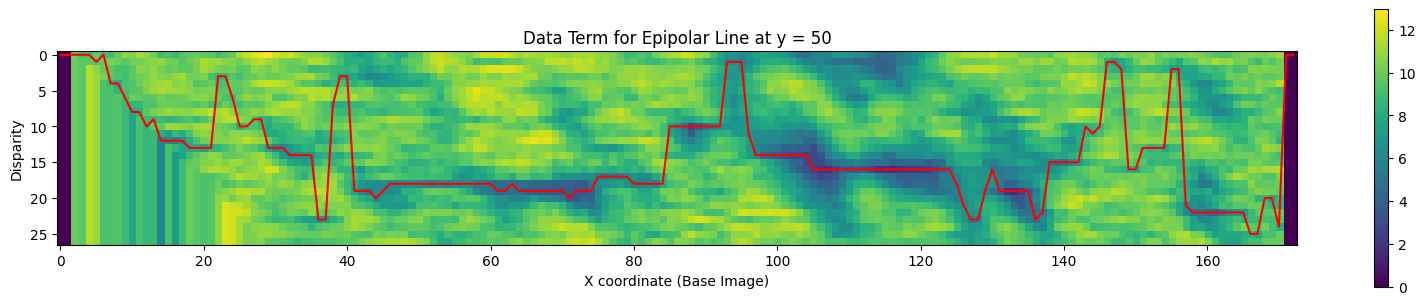

In [11]:
def display_data_term(data_term, y, disparities=None):
    epipolar_line_data = data_term[y, :, :].T
    plt.imshow(epipolar_line_data, cmap='viridis', interpolation='nearest')
    plt.colorbar(shrink=0.3)
    plt.xlabel('X coordinate (Base Image)')
    plt.ylabel('Disparity')
    plt.title('Data Term for Epipolar Line at y = {}'.format(y))
    if disparities is not None: 
        plt.plot(range(0, disparities.shape[1]), disparities[y, :], 'r-')
    plt.show()

# Display the images
y = 400 // downsample_factor
display_images(Il, Ir, y)

# Compute the data term for Il and Ir, and find disparities according to minimum data term 
patch_size = 5
# *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****    
data_term = compute_data_term(Il, Ir, max_disparity)

h, w  = Il.shape
argmin_disparities = np.zeros((h, w))
for y in range(h):
        for x in range(w):
             argmin_disparities[y, x] = np.argmin(data_term[y, x])
# *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****    

# Visualize disparities
plt.imshow(argmin_disparities, cmap='gray')
plt.show()

# Visualize data term and minimum 
y = 50
display_data_term(data_term, y, argmin_disparities)

## Q3: Optimize 1D Disparity at Given Y Offset

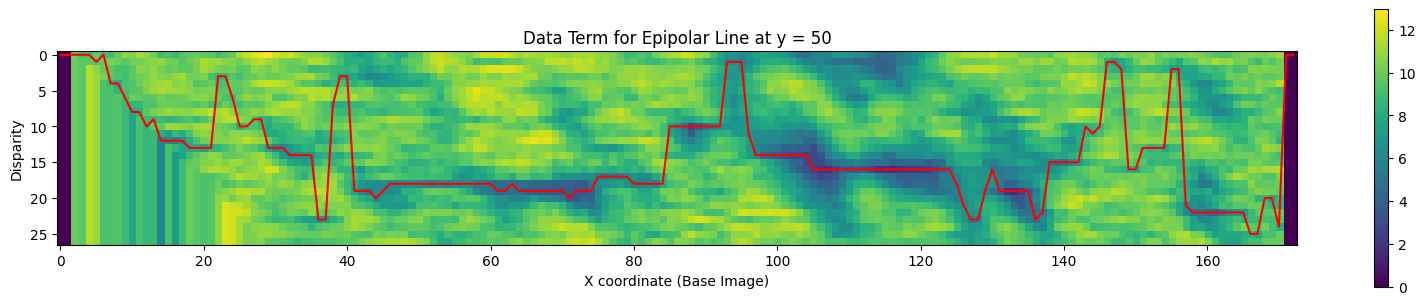

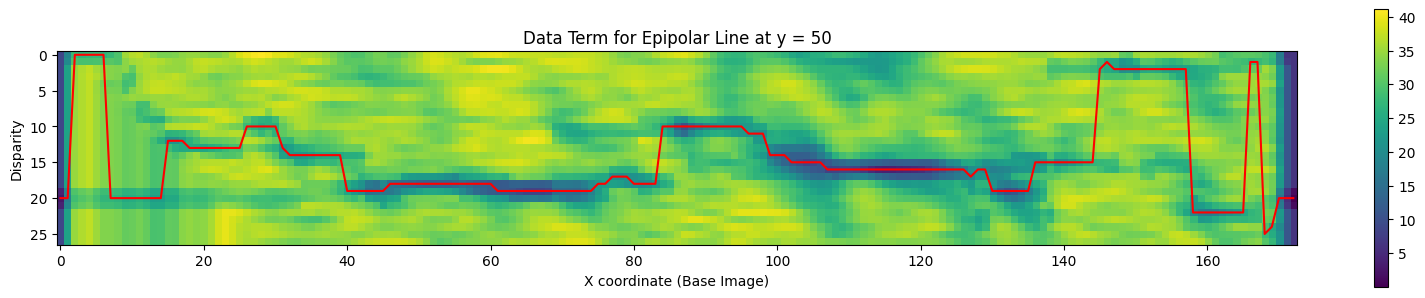

In [12]:
# See lecture 6 part B slides 6 to 13
# PLEASE NOTE: you can use data_term and y from the last cell 
# PLEASE NOTE: you may assume that messages at the boundaries of the image are 0
D = data_term[y, :]
N = D.shape[0]
P1 = 1
P2 = 5 

# *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****    
def calculate_R(d, P1, P2):
    R = np.zeros(max_disparity) 
    for i in range(max_disparity):
        if i != d:
            R[i] = P2
    if d > 0:
        R[d - 1] = P1
    if d < max_disparity - 1:
        R[d + 1] = P1
    return R

def find_messages_lr(N, P1, P2, D):
    messages = np.zeros((N, max_disparity))
    for i in range(N):
        if i == 0:
            messages[i] = np.zeros(max_disparity)
        else:
            prev_message = messages[i - 1] / P2
            d = np.argmin(prev_message +  D[i - 1], axis=0)
            R = calculate_R(d, P1, P2)
            messages[i] = prev_message + R
    return messages

def find_messages_rl(N, P1, P2, D):
    messages = np.zeros((N, max_disparity))
    for i in range(N-1, -1, -1):
        if i == N - 1:
            messages[i] = np.zeros(max_disparity)
        else:
            prev_message = messages[i + 1] / P2
            d = np.argmin(prev_message, axis=0)
            R = calculate_R(d, P1, P2)
            messages[i] = prev_message + D[i + 1] + R
    return messages

mssgs_lr = find_messages_lr(N, P1, P2, D)
mssgs_rl = find_messages_rl(N, P1, P2, D)

disparities = np.zeros(N)
E = np.zeros((N, max_disparity))
for i in range(N):
    disparities[i] = np.argmin(mssgs_lr[i] + mssgs_rl[i] + D[i])
    E[i] = mssgs_lr[i] + mssgs_rl[i] + D[i]

# *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****    

# Visualize data term and argmin 
display_data_term(data_term, y, argmin_disparities)

# Visualize data and regularization term, and optimized disparities
def display_energies(energies, disparities=None):
    plt.imshow(energies.T, cmap='viridis', interpolation='nearest')
    plt.colorbar(shrink=0.3)
    plt.xlabel('X coordinate (Base Image)')
    plt.ylabel('Disparity')
    plt.title('Data Term for Epipolar Line at y = {}'.format(y))
    if disparities is not None: 
        plt.plot(range(0, disparities.shape[0]), disparities, 'r-')
    plt.show()

display_energies(E, disparities)

In [12]:
# TWO DIMENSIONAL CASE IN PYTHON
M = data_term.shape[0]
N = data_term.shape[1]
P1 = 1
P2 = 5 

# *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****  
def calculate_R(d, P1, P2):
    R = np.zeros(max_disparity) 
    for i in range(max_disparity):
        if i != d:
            R[i] = P2
    if d > 0:
        R[d - 1] = P1
    if d < max_disparity - 1:
        R[d + 1] = P1
    return R

def find_messages(P1, P2, data_term, dx, dy):
    messages = np.zeros((M, N, max_disparity))
    if dx < 0:
        lim_x = 0
        iter_x = range(M - 1)
    else: 
        lim_x = M - 1
        iter_x = range(M - 1, -1, -1) 
    if dy < 0:
        lim_y = 0
        iter_y = range(N - 1)
    else:
        lim_y = N - 1 
        iter_y = range(N - 1, -1, -1)
    for i in iter_x:
        for j in iter_y:
            if i == lim_x or j == lim_y: # Define limits accordinly
                messages[i][j] = np.zeros(max_disparity)
            else:
                prev_message = messages[i + dx][j + dy] / P2
                d = np.argmin(prev_message, axis=0)
                R = calculate_R(d, P1, P2)
                messages[i][j] = prev_message + data_term[i + dy][j + dx] + R
    return messages

In [13]:
messages = [find_messages(P1, P2, data_term, i, j) for i, j in [(-1, -1), (0, -1), (-1, 0), (1, 1), (0, 1), (1, 0), (1, -1), (-1, 1)]]

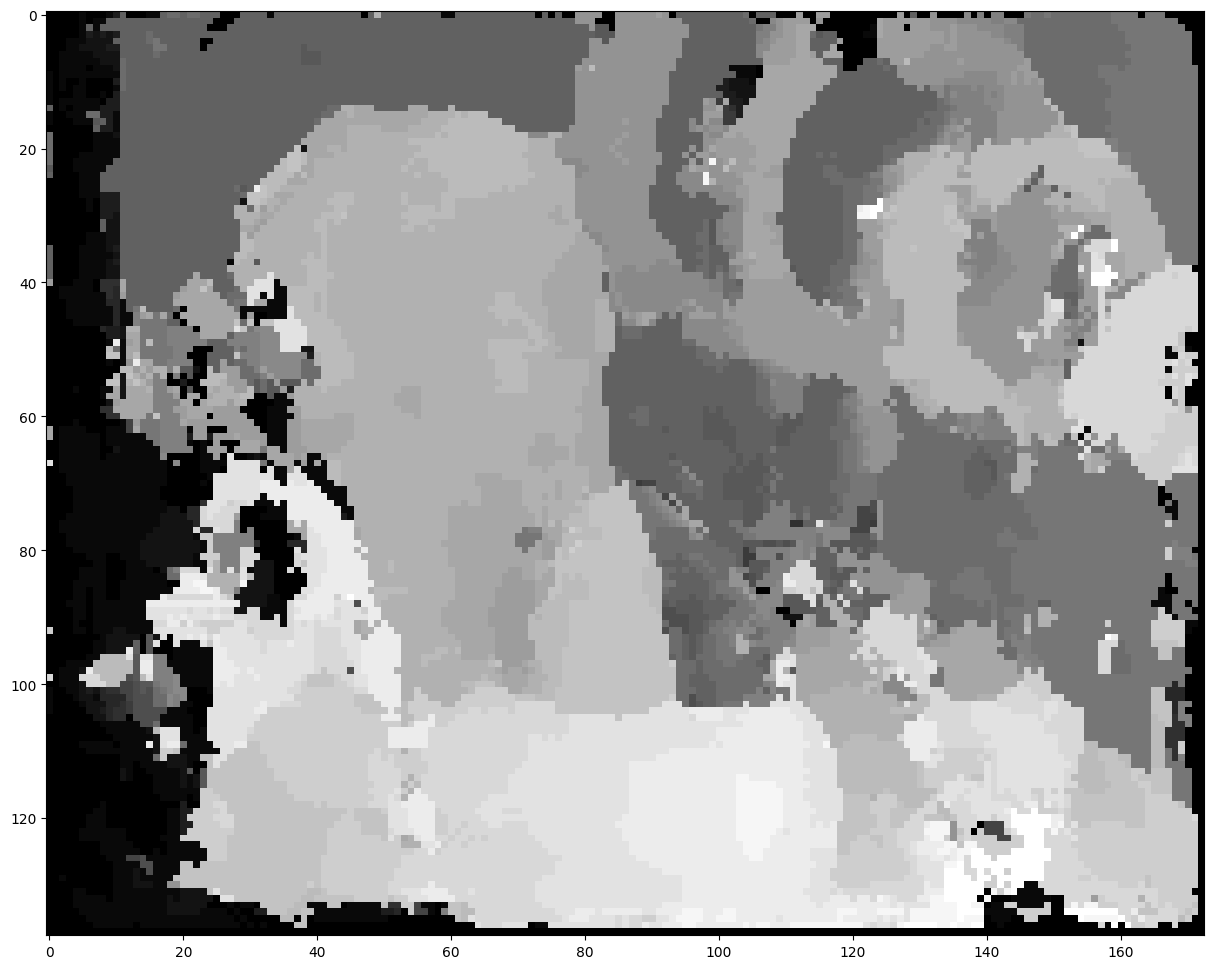

In [14]:
disparities = np.zeros((M, N))
E = np.zeros((M, N, max_disparity))
for i in range(M):
    for j in range(N):
        E[i][j] = sum(messages[k][i][j] for k in range(8)) + data_term[i][j]
        disparities[i][j] = np.argmin(E[i][j])

# Visualize disparities
plt.imshow(disparities, cmap='gray')
plt.show()